# atmodeller: Fugacity Coefficients for Non-Ideality


In [21]:
import numpy as np
import pandas as pd
from atmodeller import __version__, debug_logger, debug_file_logger
from typing import Type
from pytest import approx
from atmodeller.eos import (SaxenaFeiH2, CorkCorrespondingStates, CorkCH4,
    CorkCO,
    CorkCorrespondingStates,
    CorkFullABC,
    CorkFullCO2,
    CorkFullH2O,
    CorkH2,
    CorkSimpleCO2,
    CorkFullCO2HollAndPowell1991)

debug_logger()

In [22]:
#Plotting Tools:
import matplotlib
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', size=15)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

font={'weight':'bold',
     'size': 15}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)

### Saxena & Fei Model

In [3]:
SF_model = SaxenaFeiH2()

SF_model.get_value(temperature=2000, pressure=1)

1.0000746238654776

### Holland & Powell Model

In [4]:
HP_model: CorkCorrespondingStates = CorkH2()

print(HP_model.get_value(temperature=2000, pressure=10*1000))
#print(HP_model.fugacity_coefficient(temperature=2000, pressure=1e-3))



4.672042007568433


In [5]:
HP_model_CO: CorkCorrespondingStates = CorkCO()
HP_model_CH4: CorkCorrespondingStates = CorkCH4()

HP_model_H2O: CorkCorrespondingStates = CorkFullH2O()
HP_model_CO2: CorkCorrespondingStates = CorkFullCO2()


In [23]:
HP_CorkSimple_CO2: CorkCorrespondingStates = CorkSimpleCO2()
HP_CorkFull_CO2: CorkCorrespondingStates = CorkFullCO2HollAndPowell1991()

In [ ]:
# Tolerances to compare the test results with target output.
rtol: float = 1.0e-8
atol: float = 1.0e-8

def check_simple_Cork_gas(
    temperature: float,
    pressure: float,
    gas_type: Type[CorkCorrespondingStates],
    expected_V: float,
    expected_fugacity_coeff: float,
) -> None:
    """Checks the volume and fugacity cofficient for a given gas type using CorkSimple."""
    # The class constructor requires no arguments.
    cork: CorkCorrespondingStates = gas_type()  # type: ignore
    V: float = cork.volume(temperature, pressure)
    fugacity_coeff: float = cork.fugacity_coefficient(temperature, pressure)
    print("Fugacity Coefficient:", fugacity_coeff)
    assert V == approx(expected_V, rtol, atol)
    assert fugacity_coeff == approx(expected_fugacity_coeff, rtol, atol)

In [ ]:
print(check_simple_Cork_gas(2000, 10, CorkH2, 3.7218446244368684, 4.672042007568433))
print(HP_model.get_value(temperature=2000, pressure=10*1000))

### Kite et al.2019, Figure 2a

In [7]:
Kite_datafile_2000: str = f"data/solubility_data/H2/Kite_H2FugCoeff_2000K.csv"
K19_2000_df: pd.DataFrame = pd.read_csv(Kite_datafile_2000, names=('P_GPa', 'H2_fc'))

Kite_datafile_1673: str = f"data/solubility_data/H2/Kite_H2FugCoeff_1673K.csv"
K19_1673_df: pd.DataFrame = pd.read_csv(Kite_datafile_1673, names=('P_GPa', 'H2_fc'))

Kite_datafile_2500: str = f"data/solubility_data/H2/Kite_H2FugCoeff_2500K.csv"
K19_2500_df: pd.DataFrame = pd.read_csv(Kite_datafile_2500, names=('P_GPa', 'H2_fc'))

print(K19_2000_df['P_GPa'])

0      0.026826
1      0.363343
2      0.868118
3      1.356067
4      1.810365
5      2.466573
6      3.005000
7      3.577079
8      4.098680
9      4.721236
10     5.377444
11     5.932697
12     6.353343
13     7.228287
14     7.783539
15     8.389270
16     9.112781
17     9.668034
18    10.004551
Name: P_GPa, dtype: float64


### Looping over temperature and pressure

In [28]:
pressure_arr = np.arange(0.01, 60500, 100)
#print(pressure_arr)

In [29]:
def fugacitycoeff_func(model, temperature, pressure_range):
    model_arr = []
    for p in pressure_range:
        fug_val = model.get_value(temperature=temperature, pressure=p)
        model_arr.append(fug_val)
    return model_arr

In [16]:
HP_2000 = fugacitycoeff_func(HP_model, 2000, pressure_arr)
HP_2500 = fugacitycoeff_func(HP_model, 2500, pressure_arr)
HP_1673 = fugacitycoeff_func(HP_model, 1673, pressure_arr)

SF_2000 = fugacitycoeff_func(SF_model, 2000, pressure_arr)
SF_2500 = fugacitycoeff_func(SF_model, 2500, pressure_arr)
SF_1673 = fugacitycoeff_func(SF_model, 1673, pressure_arr)
SF_300 = fugacitycoeff_func(SF_model, 300, pressure_arr)

HP_2000_CO = fugacitycoeff_func(HP_model_CO, 2000, pressure_arr)
HP_1673_CO = fugacitycoeff_func(HP_model_CO, 1673, pressure_arr)

HP_2000_CH4 = fugacitycoeff_func(HP_model_CH4, 2000, pressure_arr)
HP_2000_H2O = fugacitycoeff_func(HP_model_H2O, 2000, pressure_arr)
HP_2000_CO2 = fugacitycoeff_func(HP_model_CO2, 2000, pressure_arr)

/Users/maggiethompson/Programs/atmodeller/atmodeller/eos_interfaces.py:105: RuntimeWarning: overflow encountered in exp
  fugacity: float = np.exp(self.ln_fugacity(temperature, pressure))  # bar
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG   

[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - temperature >= critical temperature
[15:57:33 - atmodeller.eos                 - DEBUG    ] - te

In [30]:
HP_2000_CO2Simple = fugacitycoeff_func(HP_CorkSimple_CO2, 2000, pressure_arr)
HP_2000_CO2Full = fugacitycoeff_func(HP_CorkFull_CO2, 2000, pressure_arr)


/Users/maggiethompson/Programs/atmodeller/atmodeller/eos_interfaces.py:382: RuntimeWarning: invalid value encountered in log
  ln_fugacity_coefficient: float = z - 1 - np.log(z - B) - A * np.log(1 + B / z)


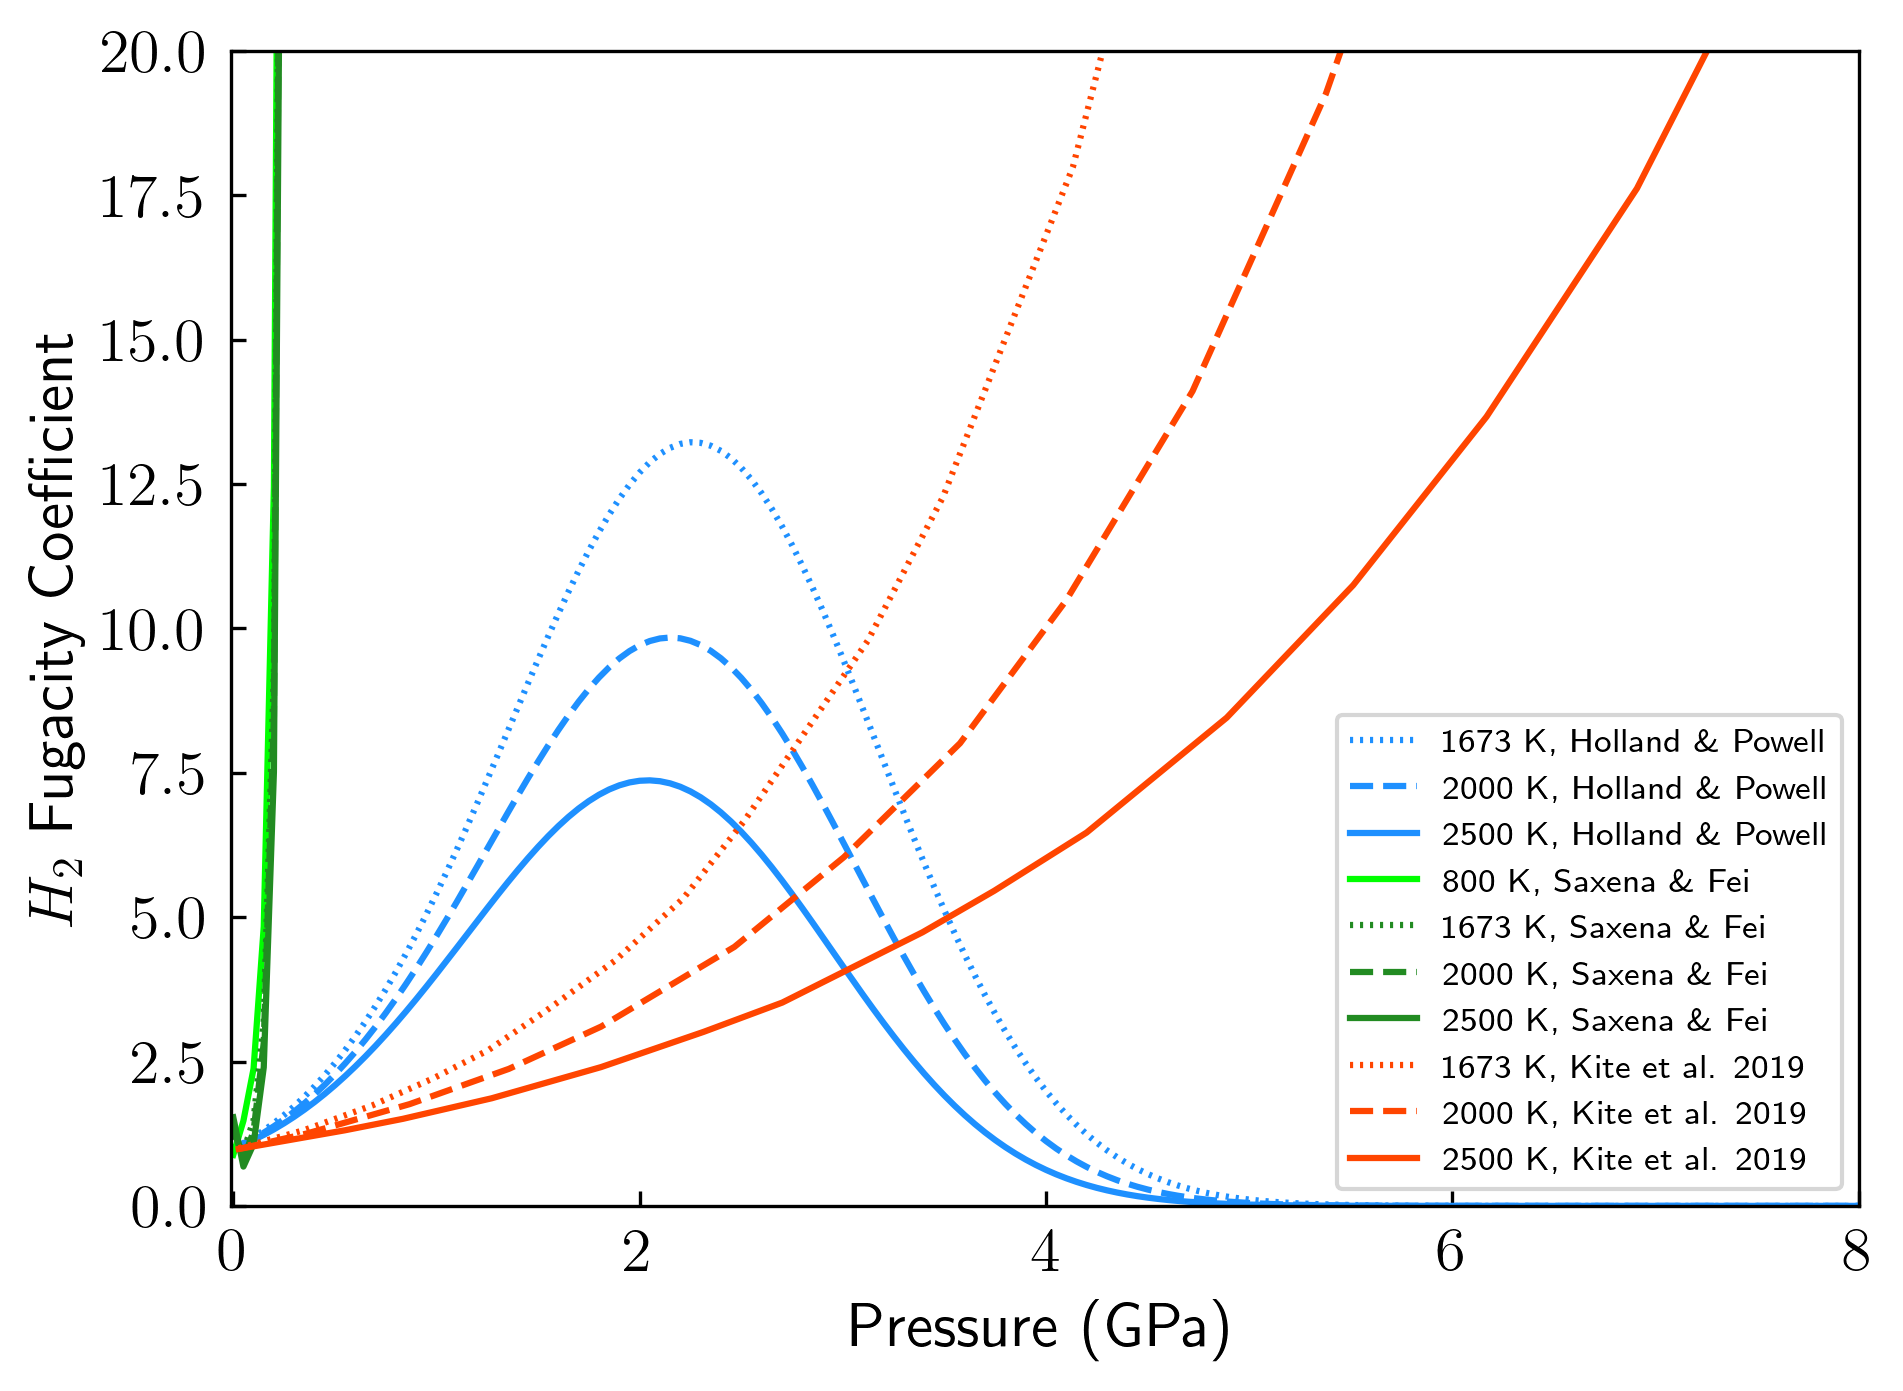

In [14]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_1673, color='dodgerblue', linestyle='dotted', label=r'1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', linestyle='--', label=r'2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2500, color='dodgerblue', label=r'2500 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SF_1673, color='forestgreen', linestyle='dotted', label=r'1673 K, Saxena \& Fei')
plt.plot(pressure_arr/1e4, SF_2000, color='forestgreen', linestyle='--', label=r'2000 K, Saxena \& Fei')
plt.plot(pressure_arr/1e4, SF_2500, color='forestgreen', label=r'2500 K, Saxena \& Fei')

plt.plot(K19_1673_df['P_GPa'], K19_1673_df['H2_fc'], color='orangered', linestyle='dotted', label=r'1673 K, Kite et al. 2019')
plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='orangered', linestyle='--', label=r'2000 K, Kite et al. 2019')
plt.plot(K19_2500_df['P_GPa'], K19_2500_df['H2_fc'], color='orangered', label=r'2500 K, Kite et al. 2019')

plt.legend(fontsize=8)
plt.ylim(0, 20)
plt.xlim(-0.01, 8)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
#plt.savefig('H2_FugacityCoefficients_ModelComparisons.jpg', dpi=1000)
plt.show()

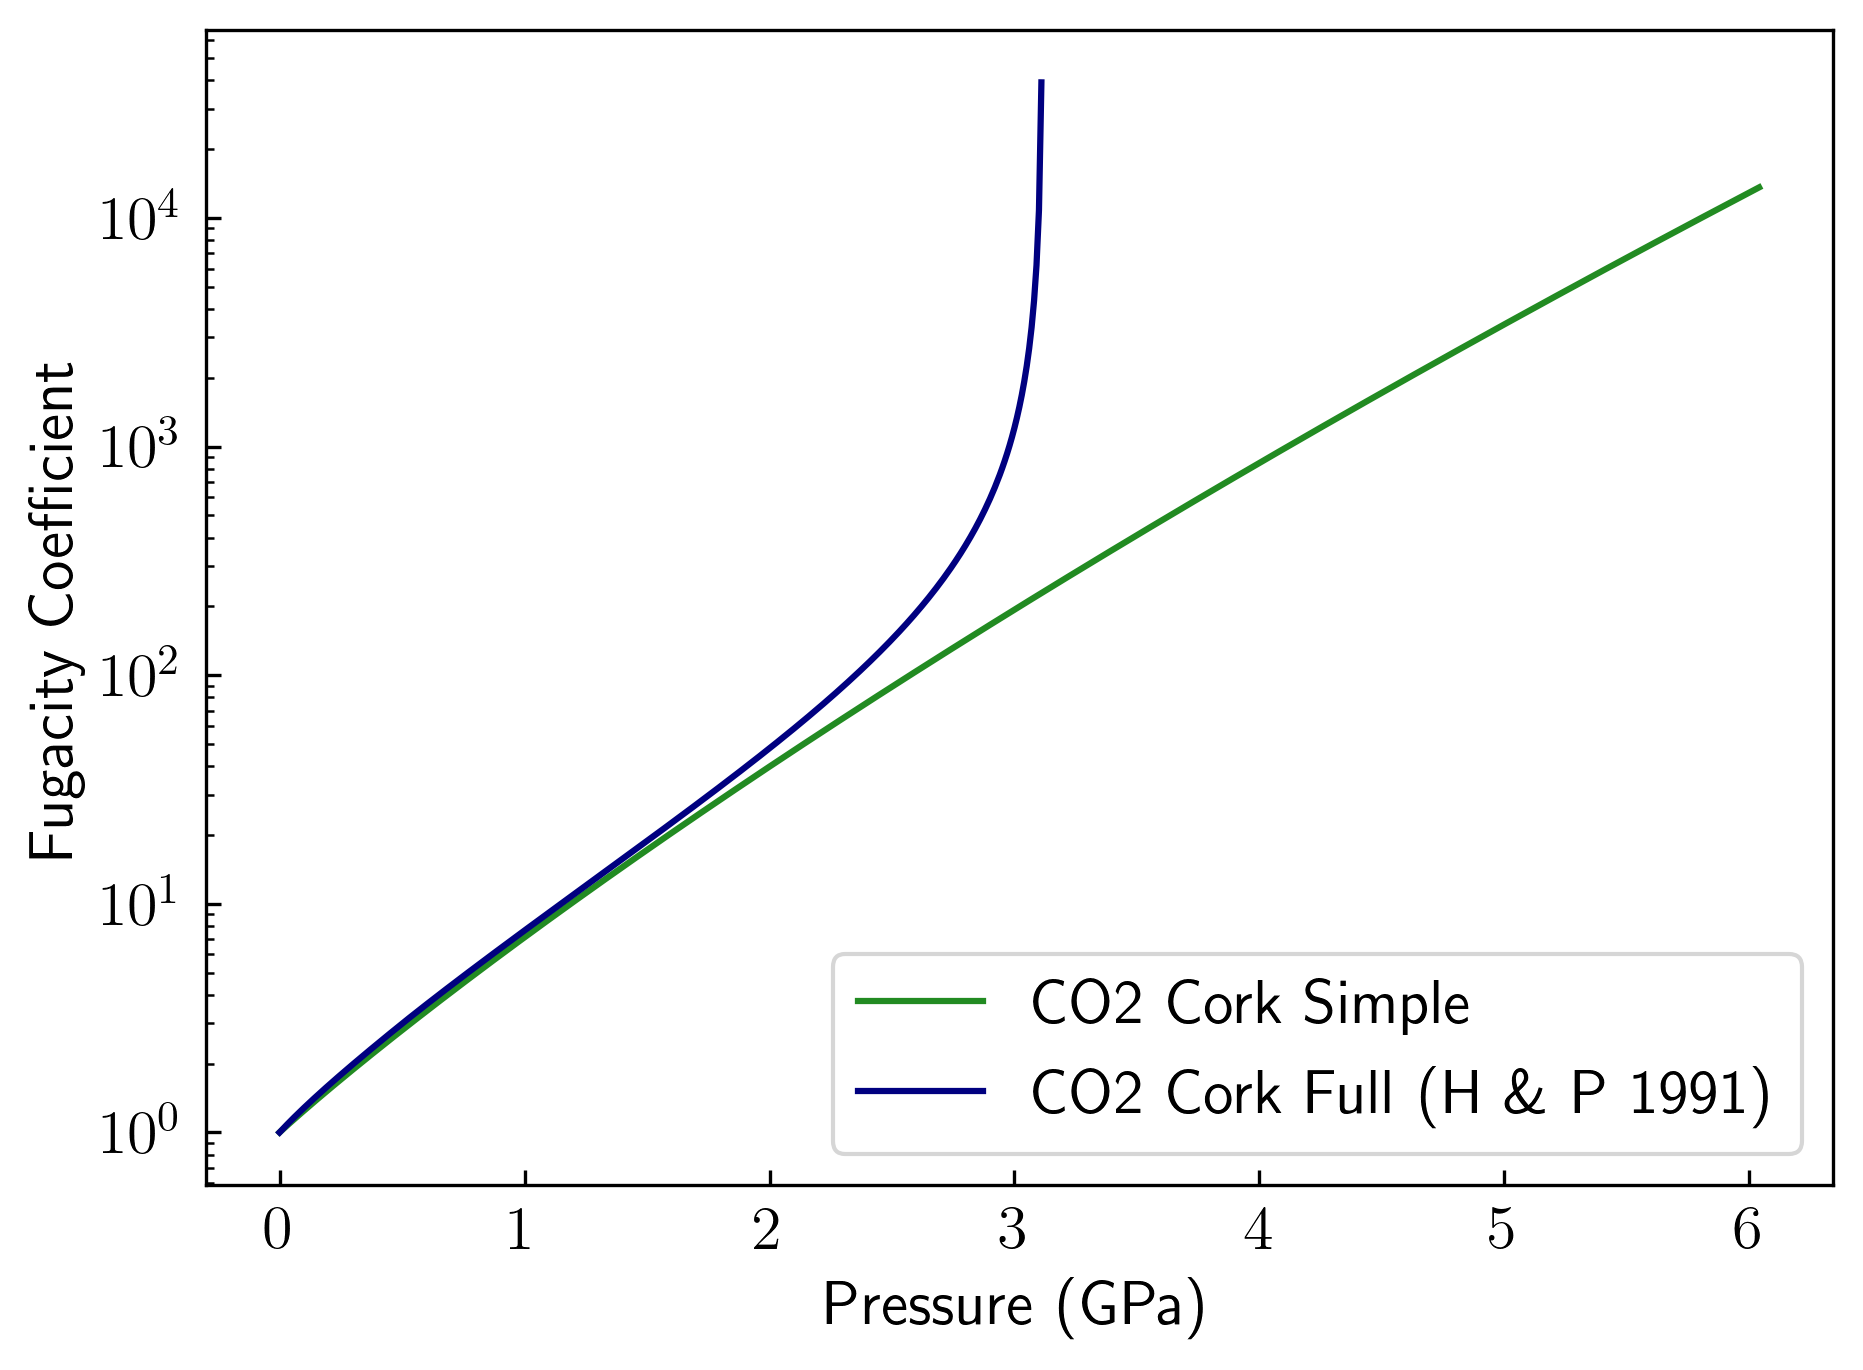

In [33]:
fig, ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_2000_CO2Simple, color='forestgreen', label='CO2 Cork Simple')
plt.plot(pressure_arr/1e4, HP_2000_CO2Full, color='navy', label=r'CO2 Cork Full (H \& P 1991)')
plt.legend()
#plt.ylim(0, 100)
plt.yscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'Fugacity Coefficient')
plt.savefig('CO2_SimplevsFullCork.jpg', dpi=1000)
plt.show()

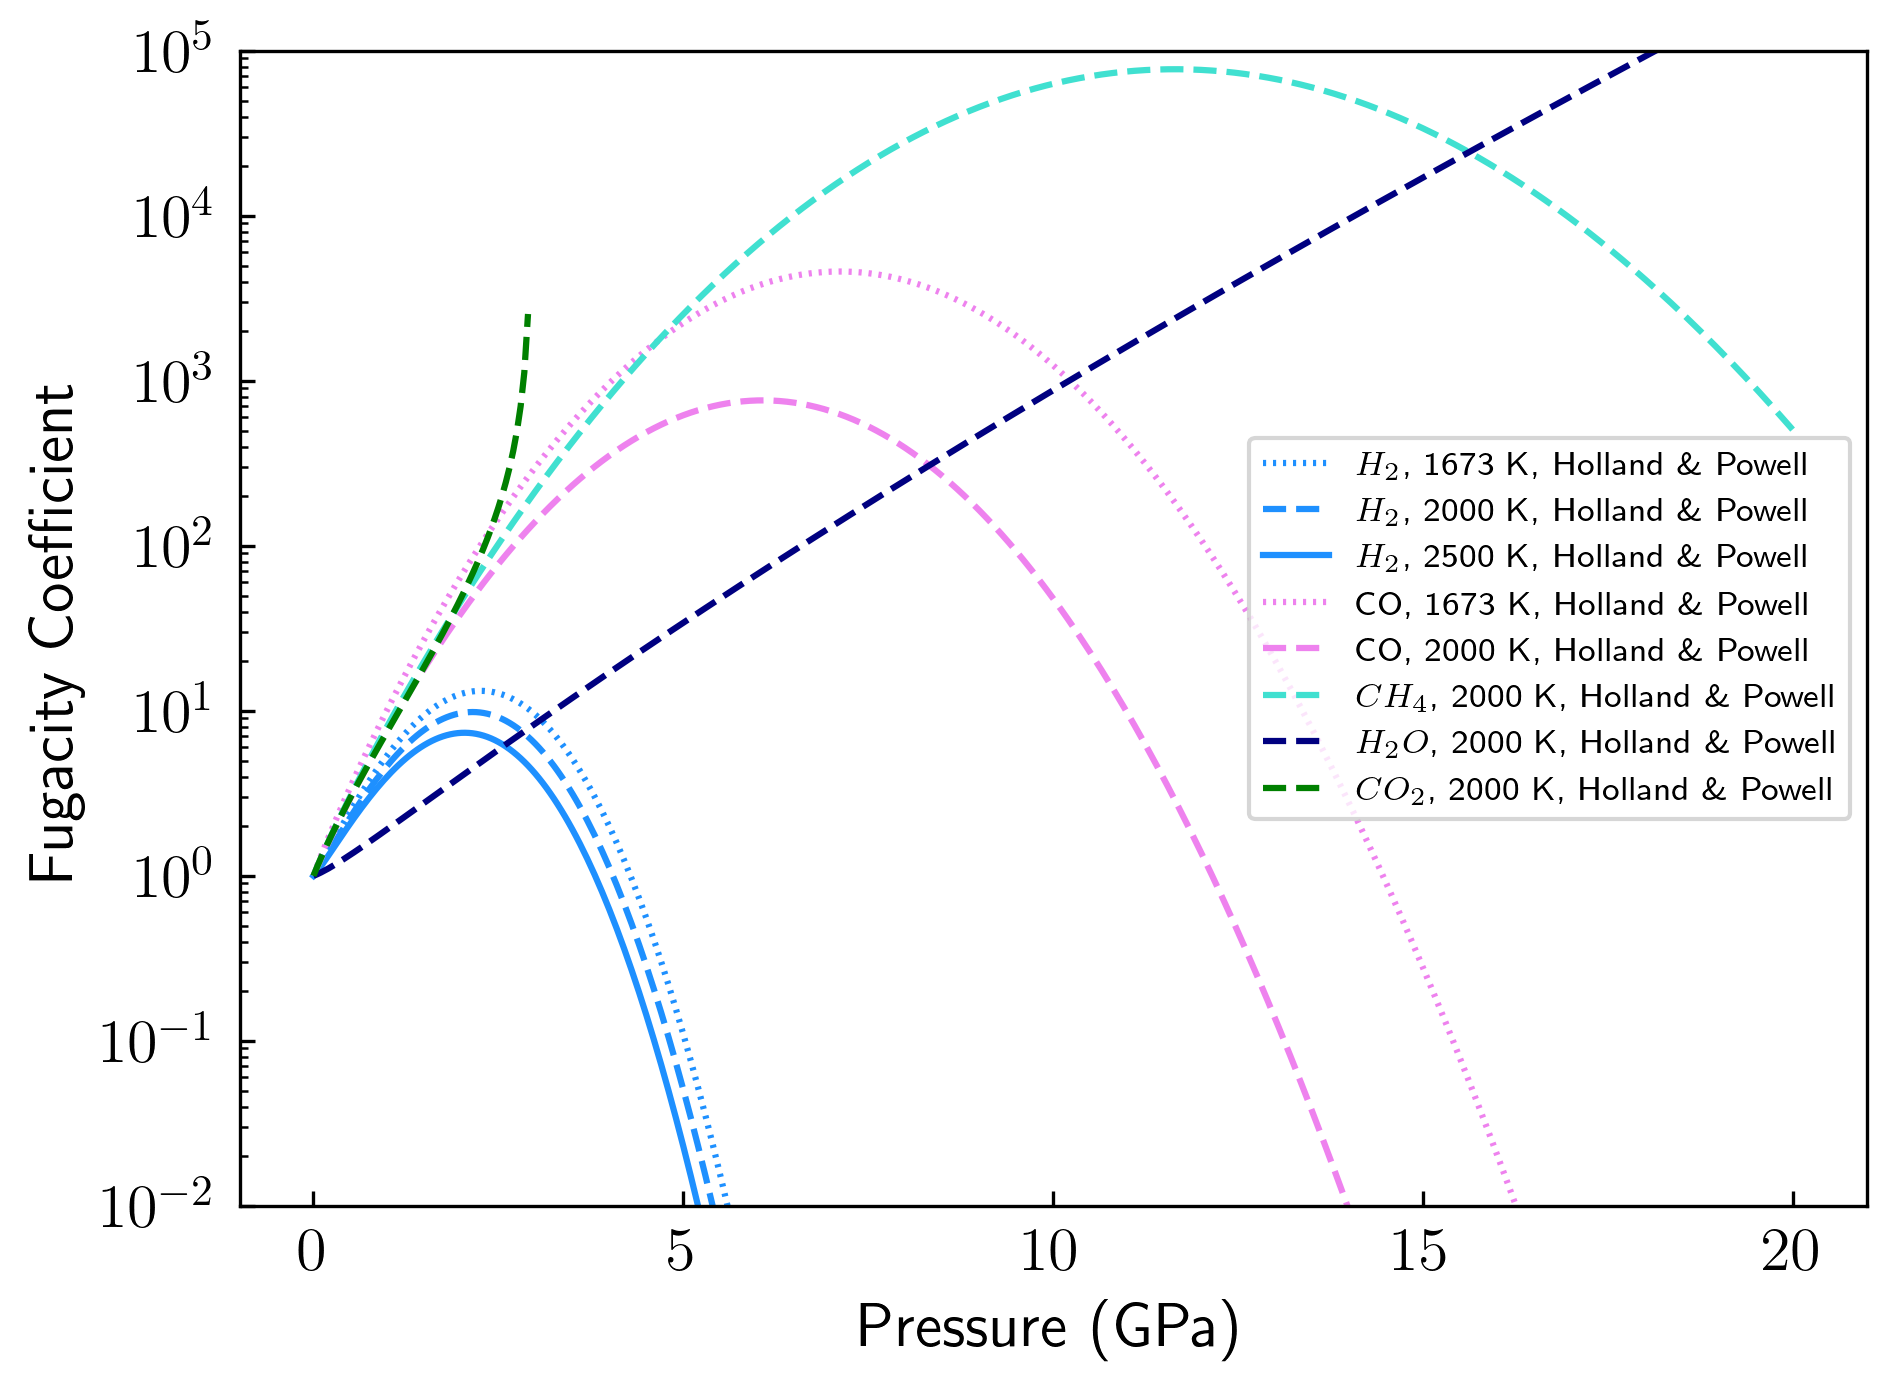

In [18]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_1673, color='dodgerblue', linestyle='dotted', label=r'$H_2$, 1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', linestyle='--', label=r'$H_2$, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2500, color='dodgerblue', label=r'$H_2$, 2500 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, HP_1673_CO, color='violet', linestyle='dotted', label=r'CO, 1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO, color='violet', linestyle='--', label=r'CO, 2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, HP_2000_CH4, color='turquoise', linestyle='--', label=r'$CH_4$, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_H2O, color='navy', linestyle='--', label=r'$H_2O$, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO2, color='green', linestyle='--', label=r'$CO_2$, 2000 K, Holland \& Powell')


plt.legend(fontsize=8)
plt.yscale('log')
plt.ylim(0.01, 1e5)
#plt.xlim(-0.01, 8)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'Fugacity Coefficient')
plt.savefig('FugacityCoefficients_HP_VariousCorrespondingStates.jpg', dpi=1000)
plt.show()

In [ ]:
print(HP_2000_CO2)

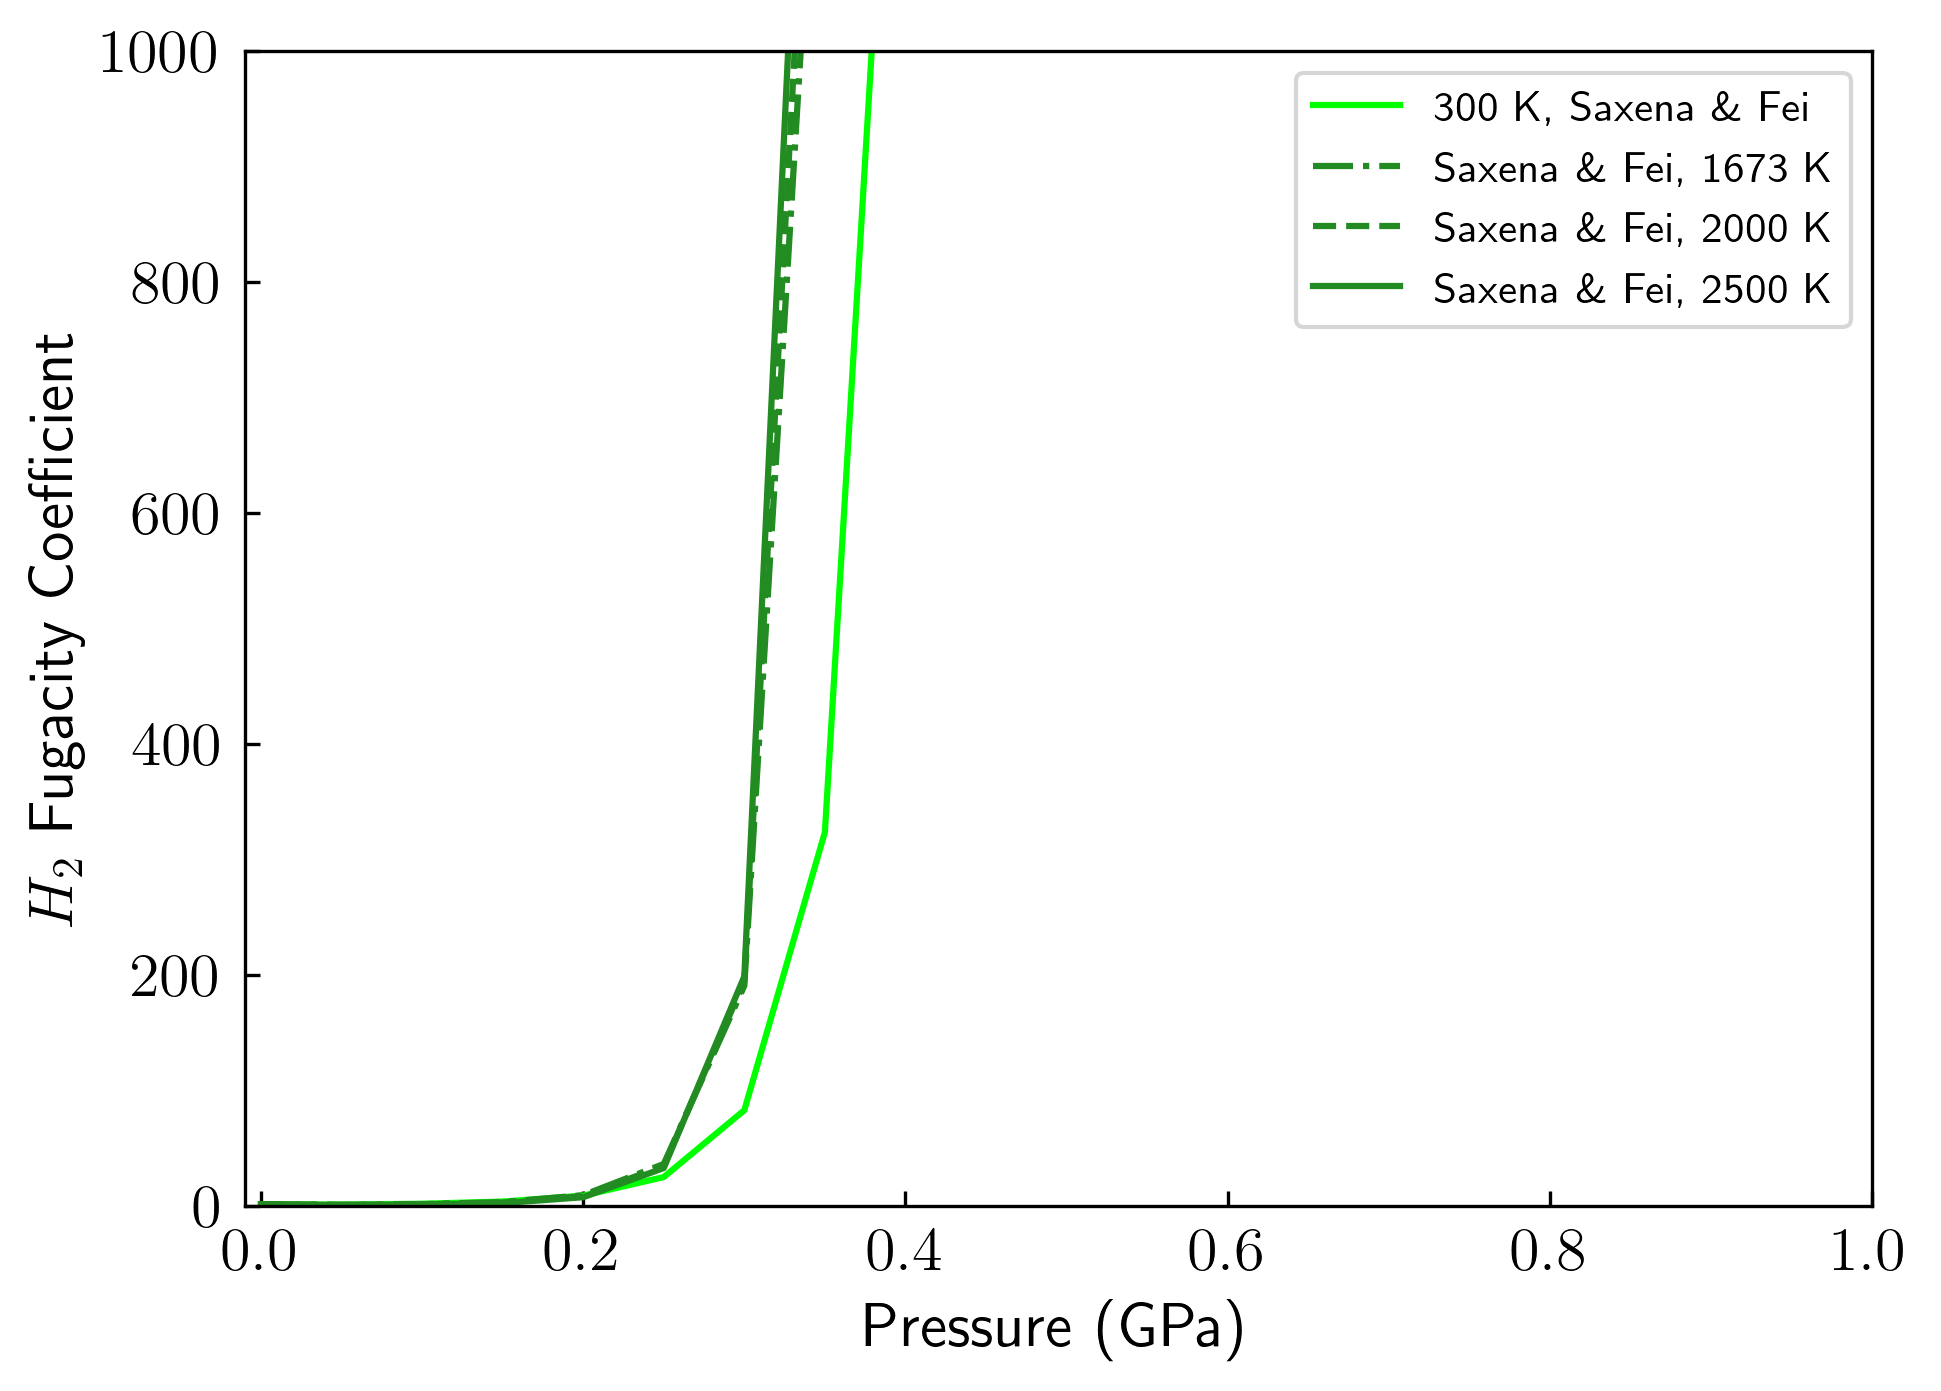

In [17]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, SF_300, color='lime', label=r'300 K, Saxena \& Fei')

plt.plot(pressure_arr/1e4, SF_1673, color='forestgreen', linestyle='-.', label=r'Saxena \& Fei, 1673 K')
plt.plot(pressure_arr/1e4, SF_2000, color='forestgreen', linestyle='--', label=r'Saxena \& Fei, 2000 K')
plt.plot(pressure_arr/1e4, SF_2500, color='forestgreen', label=r'Saxena \& Fei, 2500 K')


plt.legend(fontsize='x-small')
plt.ylim(0, 1000)
plt.xlim(-0.01, 1)
#plt.yscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
#plt.savefig('H2_FugacityCoefficients_ModelComparisons.jpg', dpi=1000)
plt.show()

In [ ]:
print(SF_1673[19])
print(pressure_arr[15])